Conversion from deconvolved signal to origin  
Author: Javier Gamero Muñoz

# General libraries

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import quality

# Load data

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

## Ideal data (origin)

In [3]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t_id = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t_id.set_index(0, inplace=True)

t_id = np.array(t_id).reshape(-1).astype(np.int32)
print(t_id.shape)

(1000,)


In [4]:
id_path = os.path.join(PATH, 'data_preproc/LightSignal_total.csv')
signals_id = pd.read_csv(id_path, sep=';', header=None)
signals_id.set_index(0, inplace=True)
print('Ideal signals df shape: ', signals_id.shape)

Ideal signals df shape:  (9325, 1000)


## Deconvolved data reduced

In [5]:
t_path = os.path.join(PATH, 'data_preproc/DeconvolvedSignal_t.csv')
t_dec = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t_dec.set_index(0, inplace=True)

t_dec = np.array(t_dec).reshape(-1).astype(np.int32)
t_dec.shape

(5050,)

In [6]:
data_path = os.path.join(os.path.join(PATH, 'data_preproc'), 'DeconvolvedSignal_us.csv')
signals_dec_us = pd.read_csv(data_path, sep=';', header=None, index_col=0)

print(signals_dec_us.shape)
signals_dec_us.head()

(9325, 1000)


,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
0,,,,,,,,,,,,,,,,,,,,,
0_1,-0.013636,0.003455,5.652545,28.486182,44.607818,35.096364,21.015091,11.813455,7.580909,6.095455,...,-0.016545,-0.031273,-0.032909,-0.032000,-0.023455,-0.021091,-0.014000,-0.017818,-0.018545,-0.02250
0_4,0.000182,0.000727,1.786182,12.082909,23.939818,23.189455,14.626545,8.413455,5.297636,3.896545,...,0.001455,0.001273,0.002000,0.000182,-0.000909,-0.002182,-0.005818,-0.005273,-0.003818,-0.00250
0_6,0.004182,-0.002182,4.107455,18.174182,28.416909,23.247273,13.882909,7.938727,4.708000,3.035455,...,0.005455,0.005273,0.007091,0.008364,0.009091,0.010182,0.008909,0.006364,0.009455,0.00475
0_8,-0.008000,0.303091,5.657455,16.356182,20.395273,15.051636,8.831818,5.433091,3.595455,2.263455,...,-0.006182,-0.004909,-0.011818,-0.012000,-0.010727,-0.006727,-0.008727,-0.009818,-0.005818,-0.00800
0_9,0.007636,0.073455,3.116182,15.448909,23.388909,18.269273,11.052000,6.872364,4.603273,2.915636,...,0.000909,0.001091,0.001091,0.005091,0.006909,0.008727,0.006545,0.001273,0.006182,0.00525


In [13]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', ylabel='# photons', sep=False,
                figsize=(5,5)): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        fig, axs = plt.subplots(1,len(v), figsize=figsize)
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.figure(figsize=figsize)
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return
    
# this function will plot the loss results of NN training. It should be used 
# to check if the NN is oferfitting 
def NN_trainPlot(history): 
    fig, ax = plt.subplots(1,1)

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    ax.plot(loss, 'r.', label='Train')
    ax.plot(val_loss, 'b-', label='Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc='best')

    plt.show()

# Processing data

In [7]:
from sklearn.model_selection import train_test_split
X = np.array(signals_id.iloc[:,:].values) 
y = np.array(signals_dec_us.iloc[:,:].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

X_train = X_train[:, :, np.newaxis].astype('float64')
y_train = y_train.astype('float64')

X_test = X_test[:,:, np.newaxis].astype('float64')
y_test = y_test.astype('float64')

In [8]:
print(X_train.shape)
print(X_test.shape)

(6527, 1000, 1)
(2798, 1000, 1)


In [9]:
timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(1000, 1)


# Deep learning models

## Models

In [21]:
def testModel(model, history, t, X_test, y_test, plot=True, i=5):

    if history!=None: 
        NN_trainPlot(history)

    y_pred = model.predict(X_test) 
    y_pred = y_pred[:,:,0] # adjust to (n_samples, n_timesteps)

    if plot:
        i=i
        v = [X_test[i,:,0], y_test[i,:], np.array(y_pred[i,:])]
        plotSignals(t, v, ['Total', 'GT', 'Pred'], sep='True', figsize=(15,5))

    # e_found = 0
    # for GT, pred in zip(y_test, y_pred): 
    #     q = quality(t, GT, pred)
    #     if q.isElectronExctracted(): e_found+=1

    # print('Ratio e total found: {0}%'.format(e_found / y_test.shape[0] * 100))

### Model: simple LSTM (bidirectional)

In [11]:
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import set_random_seed

def model_SimpleBidirectional(n_hidden_layers=1, n_neurons=[16], 
                              activation=['tanh'], timesteps=985, features=1, 
                              seed=2023):

    set_random_seed(seed)
    
    init = True
    input_shape=(timesteps, features)

    model = Sequential()
    for i in range(n_hidden_layers): 
        if init: 
            # also adds the input layer
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True,
                                         input_shape = input_shape
                                         ))) 
            init=False
            
        else: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True)))
    
    model.add(Dense(1, activation='linear')) # output layer
    
    return model

Epoch 1/10
143/143 [==============================] - 34s 235ms/step - loss: 2.5232 - val_loss: 2.0507
Epoch 2/10
143/143 [==============================] - 41s 289ms/step - loss: 1.8012 - val_loss: 1.4770
Epoch 3/10
143/143 [==============================] - 43s 301ms/step - loss: 1.2619 - val_loss: 1.0178
Epoch 4/10
143/143 [==============================] - 43s 298ms/step - loss: 0.9221 - val_loss: 0.8108
Epoch 5/10
143/143 [==============================] - 43s 298ms/step - loss: 0.7715 - val_loss: 0.7157
Epoch 6/10
143/143 [==============================] - 43s 302ms/step - loss: 0.6899 - val_loss: 0.6543
Epoch 7/10
143/143 [==============================] - 43s 299ms/step - loss: 0.6461 - val_loss: 0.6222
Epoch 8/10
143/143 [==============================] - 44s 306ms/step - loss: 0.6196 - val_loss: 0.5981
Epoch 9/10
143/143 [==============================] - 44s 305ms/step - loss: 0.5988 - val_loss: 0.6092
Epoch 10/10
143/143 [==============================] - 43s 304ms/step - l

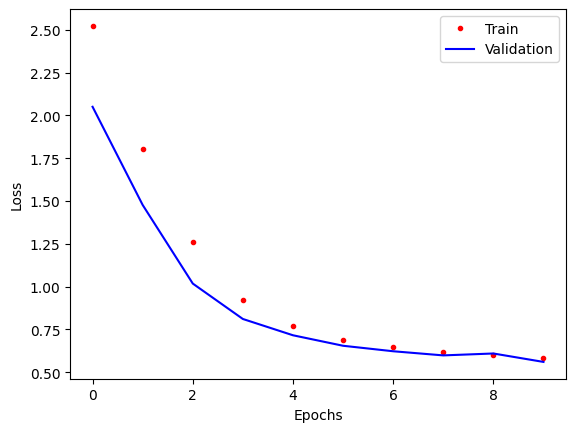

88/88 [==============================] - 5s 52ms/step


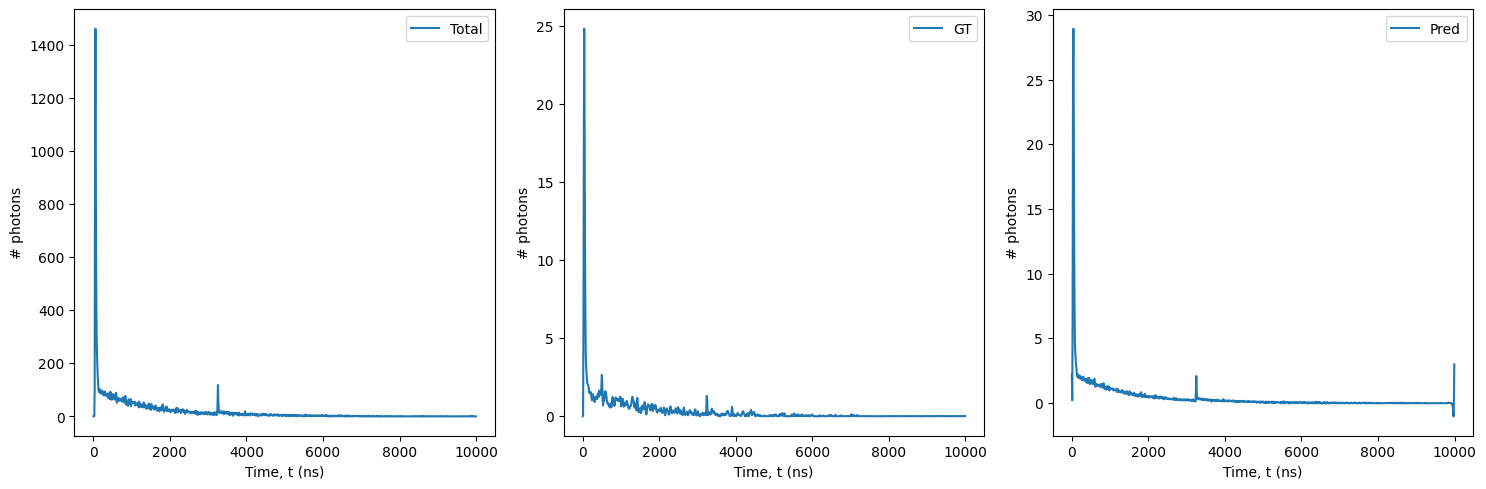

Ratio e total found: 100.0%


In [20]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['sigmoid'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, t_id, X_test, y_test, i=24)

Epoch 1/10
143/143 [==============================] - 30s 203ms/step - loss: 2.2748 - val_loss: 1.7119
Epoch 2/10
143/143 [==============================] - 28s 196ms/step - loss: 1.2460 - val_loss: 0.8480
Epoch 3/10
143/143 [==============================] - 28s 196ms/step - loss: 0.7681 - val_loss: 0.6650
Epoch 4/10
143/143 [==============================] - 28s 196ms/step - loss: 0.6374 - val_loss: 0.5825
Epoch 5/10
143/143 [==============================] - 28s 195ms/step - loss: 0.5777 - val_loss: 0.5481
Epoch 6/10
143/143 [==============================] - 28s 193ms/step - loss: 0.5532 - val_loss: 0.5338
Epoch 7/10
143/143 [==============================] - 28s 195ms/step - loss: 0.5078 - val_loss: 0.5492
Epoch 8/10
143/143 [==============================] - 28s 194ms/step - loss: 0.4916 - val_loss: 0.4601
Epoch 9/10
143/143 [==============================] - 28s 195ms/step - loss: 0.4726 - val_loss: 0.5022
Epoch 10/10
143/143 [==============================] - 28s 194ms/step - l

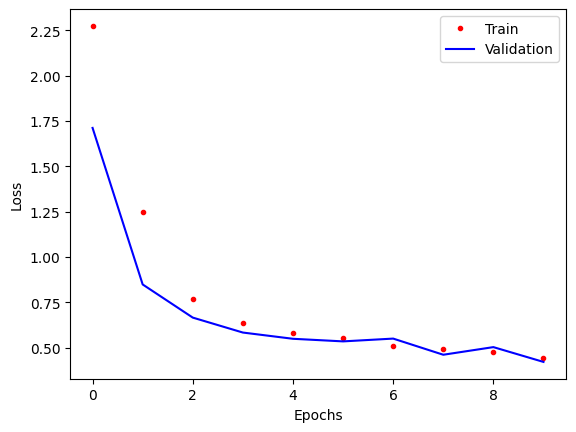

88/88 [==============================] - 4s 44ms/step


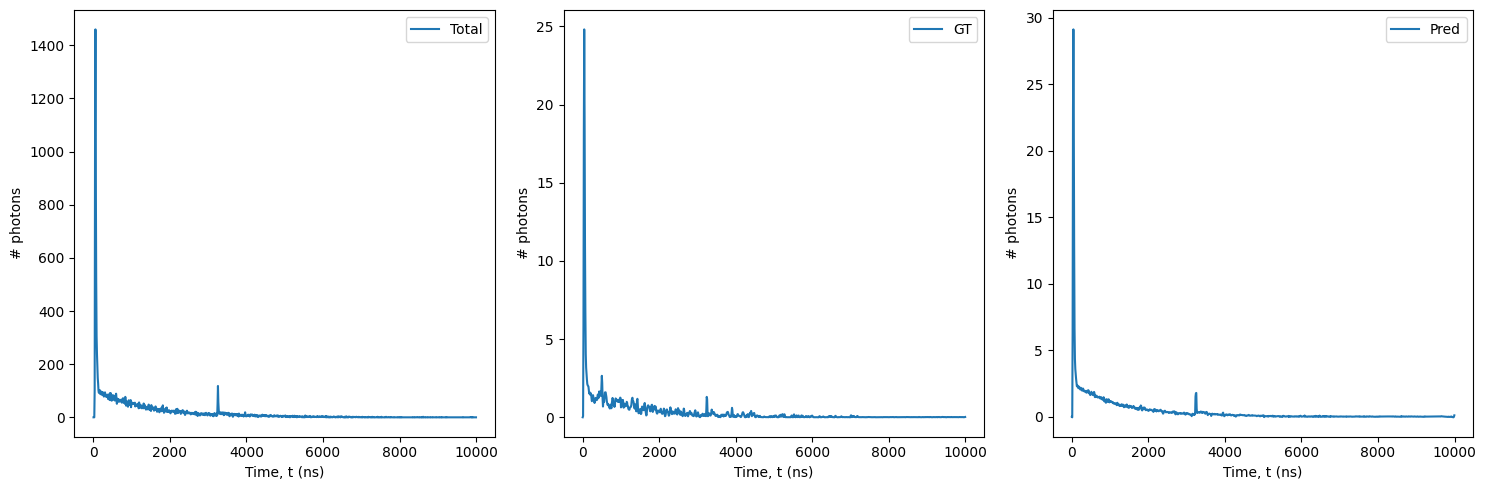

In [23]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, t_id, X_test, y_test, i=24)

Epoch 1/10
143/143 [==============================] - 32s 209ms/step - loss: 2.2764 - val_loss: 1.8109
Epoch 2/10
143/143 [==============================] - 29s 204ms/step - loss: 1.5295 - val_loss: 1.1445
Epoch 3/10
143/143 [==============================] - 29s 204ms/step - loss: 1.0159 - val_loss: 0.8372
Epoch 4/10
143/143 [==============================] - 28s 199ms/step - loss: 0.7601 - val_loss: 0.6654
Epoch 5/10
143/143 [==============================] - 28s 198ms/step - loss: 0.6586 - val_loss: 0.7379
Epoch 6/10
143/143 [==============================] - 28s 195ms/step - loss: 0.6107 - val_loss: 0.5864
Epoch 7/10
143/143 [==============================] - 28s 198ms/step - loss: 0.5736 - val_loss: 0.6870
Epoch 8/10
143/143 [==============================] - 28s 197ms/step - loss: 0.5501 - val_loss: 0.4878
Epoch 9/10
143/143 [==============================] - 28s 198ms/step - loss: 0.5261 - val_loss: 0.5526
Epoch 10/10
143/143 [==============================] - 28s 199ms/step - l

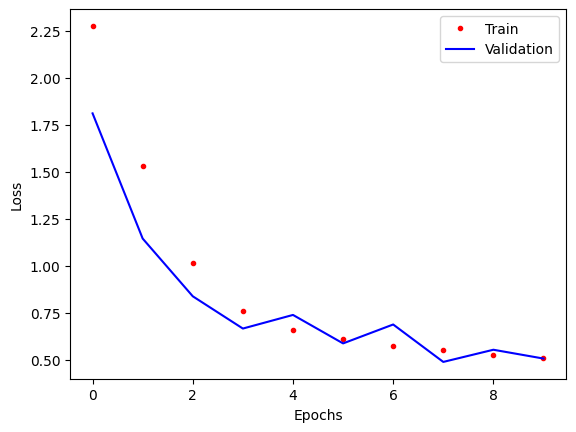

88/88 [==============================] - 4s 45ms/step


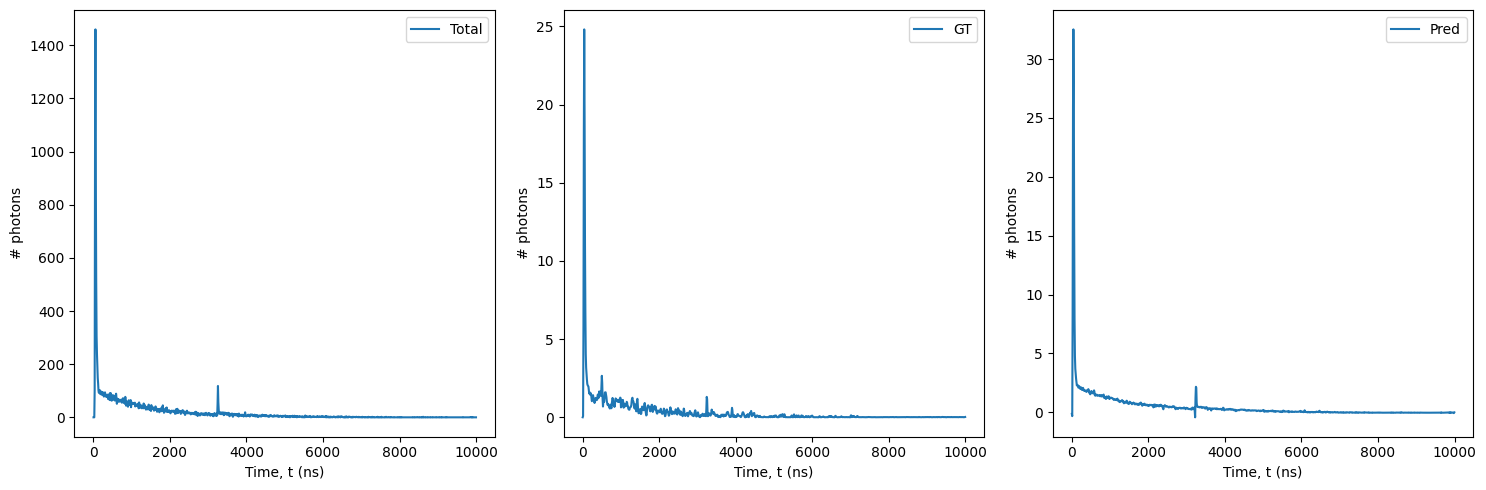

In [22]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, t_id, X_test, y_test, i=24)

Epoch 1/10
143/143 [==============================] - 30s 200ms/step - loss: 2.4928 - val_loss: 2.1843
Epoch 2/10
143/143 [==============================] - 28s 195ms/step - loss: 2.2316 - val_loss: 2.1100
Epoch 3/10
143/143 [==============================] - 29s 202ms/step - loss: 2.1632 - val_loss: 2.0129
Epoch 4/10
143/143 [==============================] - 29s 203ms/step - loss: 2.0381 - val_loss: 1.9282
Epoch 5/10
143/143 [==============================] - 29s 204ms/step - loss: 2.0365 - val_loss: 1.9174
Epoch 6/10
143/143 [==============================] - 28s 199ms/step - loss: 2.0638 - val_loss: 1.9067
Epoch 7/10
143/143 [==============================] - 28s 198ms/step - loss: 2.0096 - val_loss: 1.8682
Epoch 8/10
143/143 [==============================] - 28s 196ms/step - loss: 2.0029 - val_loss: 1.8657
Epoch 9/10
143/143 [==============================] - 28s 198ms/step - loss: 2.0506 - val_loss: 2.3232
Epoch 10/10
143/143 [==============================] - 30s 208ms/step - l

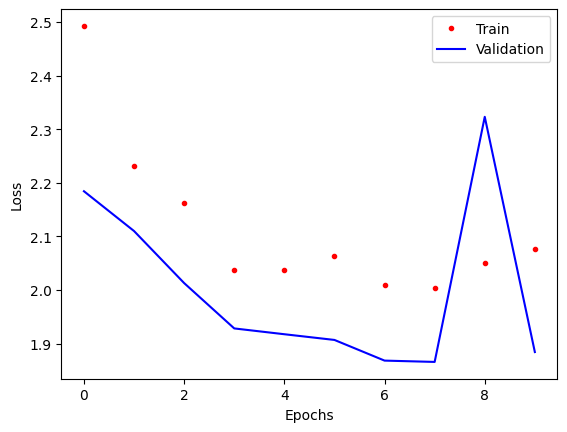

88/88 [==============================] - 4s 45ms/step


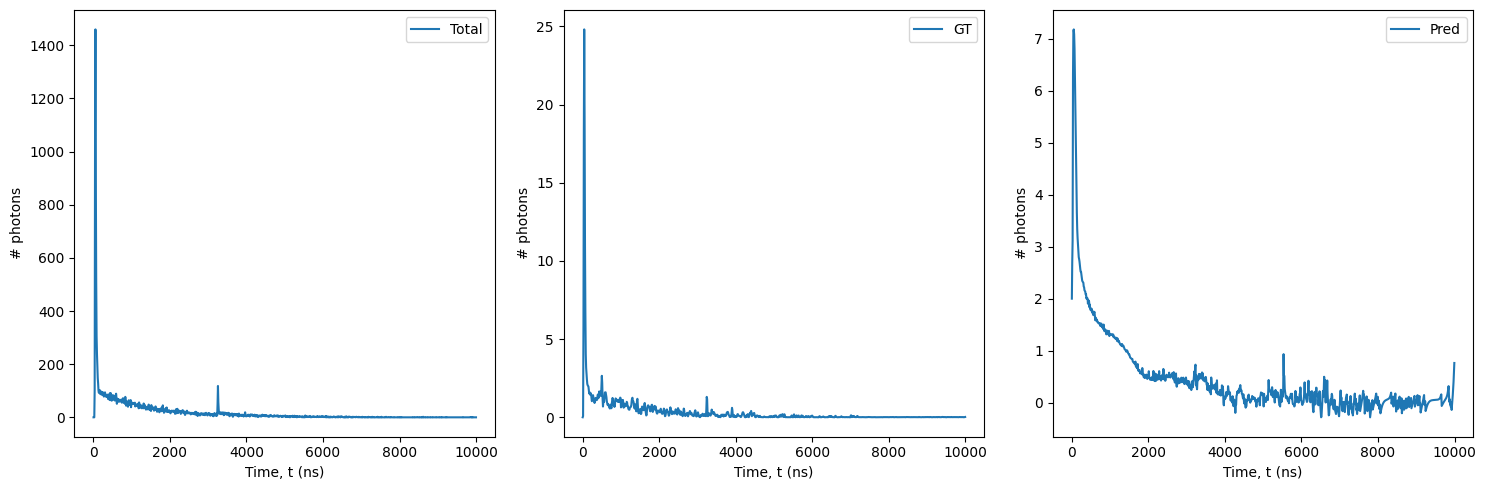

In [24]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='SGD', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, t_id, X_test, y_test, i=24)

<center>

|Model              |epochs       |MSE
|:-----------------:|:-----------:|---------|
|64/sigmoid/adam    |10           |0.56
|64/tanh/adam       |10           |0.42
|64/tanh/RMSprop    |10           |0.50
|64/tanh/SGD        |10           |>1

Epoch 1/30
143/143 [==============================] - 30s 199ms/step - loss: 2.2748 - val_loss: 1.7119
Epoch 2/30
143/143 [==============================] - 28s 193ms/step - loss: 1.2460 - val_loss: 0.8480
Epoch 3/30
143/143 [==============================] - 28s 193ms/step - loss: 0.7681 - val_loss: 0.6650
Epoch 4/30
143/143 [==============================] - 28s 195ms/step - loss: 0.6374 - val_loss: 0.5825
Epoch 5/30
143/143 [==============================] - 28s 193ms/step - loss: 0.5777 - val_loss: 0.5481
Epoch 6/30
143/143 [==============================] - 28s 194ms/step - loss: 0.5532 - val_loss: 0.5338
Epoch 7/30
143/143 [==============================] - 28s 194ms/step - loss: 0.5078 - val_loss: 0.5492
Epoch 8/30
143/143 [==============================] - 28s 193ms/step - loss: 0.4916 - val_loss: 0.4601
Epoch 9/30
143/143 [==============================] - 28s 193ms/step - loss: 0.4726 - val_loss: 0.5022
Epoch 10/30
143/143 [==============================] - 28s 197ms/step - l

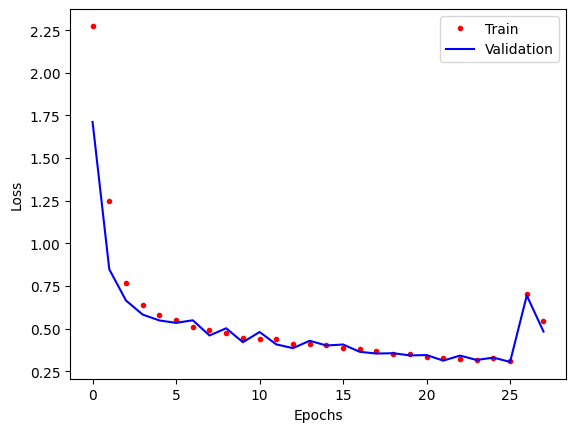

88/88 [==============================] - 4s 45ms/step


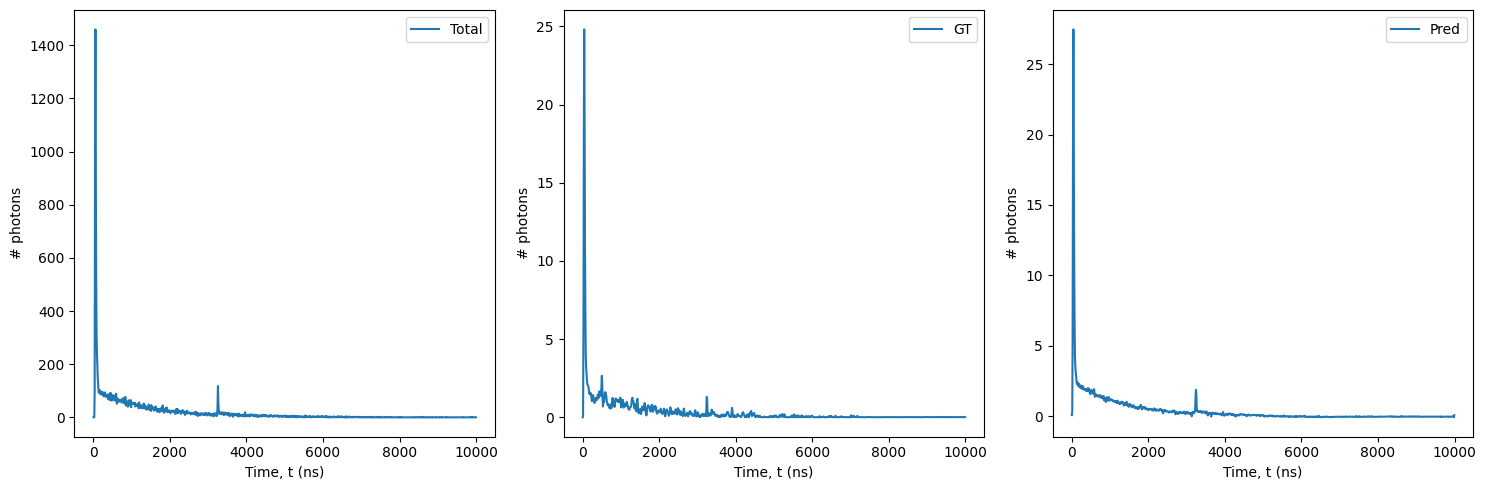

In [26]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=30, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, t_id, X_test, y_test, i=24)

<center>

|Model              |epochs       |MSE
|:-----------------:|:-----------:|---------|
|64/sigmoid/adam    |10           |0.56
|64/tanh/adam       |10           |0.42
|64/tanh/RMSprop    |10           |0.50
|64/tanh/SGD        |10           |>1
|64/tanh/adam       |28           |0.30

In [30]:
MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, 'conversion_bidirLSTM.keras'), overwrite=True, 
           save_format='tf')